In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from tqdm import tqdm

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
    "enem" : "ENEM",
    "enemreg" : "ENEM Reg.",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "LGBMRegressor" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "M2FGBClassifier" : "#8da0cb",
    "M2FGBClassifier_v1" : "#8da0cb",
    "M2FGBClassifier_tpr" : "#8da0cb",
    "M2FGBClassifier_pr" : "#8da0cb",
    "M2FGBRegressor" : "#8da0cb",
    "MinimaxPareto" : "pink",
    "MinimaxPareto_tpr" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "LGBMRegressor" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGBClassifier_tpr" : "M²FGB (tpr)",
    "M2FGBClassifier_pr" : "M²FGB (pr)",
    "M2FGBClassifier" : "M²FGB",
    "M2FGBRegressor" : "M²FGB",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF",
    "MinimaxPareto_tpr" : "MMPF (tpr)",
    "MinMaxFairRegressor" : "MinMaxFair",
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBMClassifier" in key or "eod" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

## Functions

In [3]:
SEED = 0
np.random.seed(SEED)

## Convergence Plots

In [4]:
import sys
sys.path.append("../scripts")
import data
import models
import utils

In [5]:
args = {
    "dataset" : "german",
    "n_groups" : 4,
}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
    data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Male,Older 30': 0, 'Female,Under 30': 1, 'Male,Under 30': 2, 'Female,Older 30': 3}


In [6]:
params = {
    "learning_rate" : 0.05,
    "max_depth" : 3,
    "min_child_weight" : 1e-3,
    #"reg_lambda" : 1000
}

In [9]:
def call_model(iter, method):
    if method == "m2fgb":
        return models.M2FGBClassifier(
            multiplier_learning_rate=0.05,
            fair_weight=0.5,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            random_state=SEED,
            **params
        )
    elif method == "lgbm":
        return models.M2FGBClassifier(
            multiplier_learning_rate=0.01,
            fair_weight=0,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            random_state=SEED,
            **params
        )


iters_list = list(range(5, 100, 5))
methods_names = ["lgbm", "m2fgb"]
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

for method in methods_names:
    for iter in tqdm(iters_list):
        model = call_model(iter, method)
        #start = time()
        model.fit(X_train, Y_train, A_train)
        #end = time()

        #computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "true_positive_rate"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "true_positive_rate"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 14.24it/s]


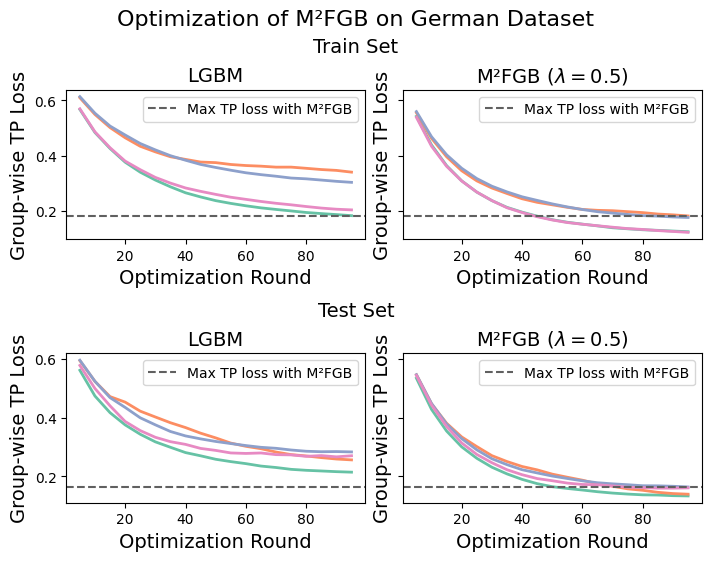

In [20]:
fig = plt.figure(constrained_layout=True, figsize = (7, 5.5))
fig.suptitle('Optimization of M²FGB on German Dataset', fontsize = 16)

subfigs = fig.subfigures(nrows=2, ncols=1)
sets = ["train", "test"]
set_names = ["Train Set", "Test Set"]
better_methods_names = {
    "lgbm" : "LGBM",
    "m2fgb" : "M²FGB ($\lambda = 0.5$)"
}
for row, subfig in enumerate(subfigs):
    subfig.suptitle(set_names[row], fontsize = 14)

    max_score = np.max(score[sets[row]]["m2fgb"][-1, :])
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)


    for col, ax in enumerate(axs):
        method = methods_names[col]

        ax.set_title(better_methods_names[method], fontsize = 14)

        # set color cycle to Pastel2
        ax.set_prop_cycle(color=plt.cm.Set2.colors)
        
        for ng in range(args["n_groups"]):
            ax.plot(iters_list, score[sets[row]][method][:, ng], lw = 2)


        ax.set_xlabel("Optimization Round", fontsize = 14)
        ax.set_ylabel("Group-wise TP Loss", fontsize = 14)

        ax.axhline(max_score, color = "#606060", linestyle = "--", label = "Max TP loss with M²FGB")
        ax.legend(loc = "upper right")
        #ax.grid(True)

plt.savefig("../figs/convergence_german.pdf", dpi = 300)
plt.show()

## $\lambda$ parameter

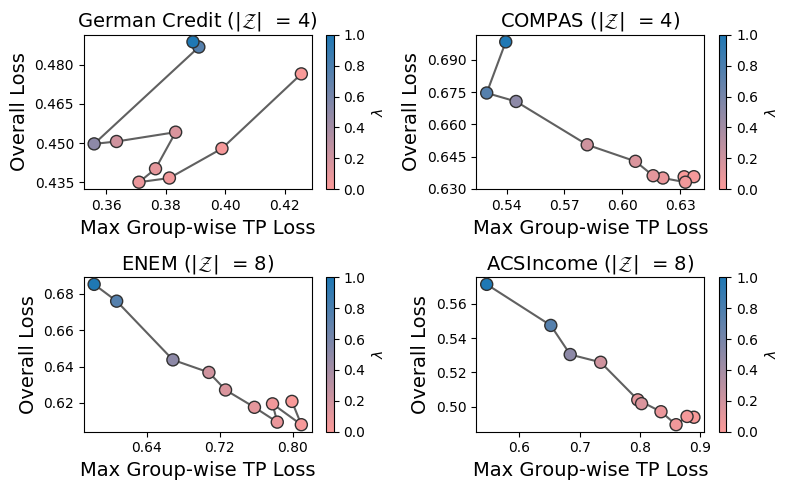

In [23]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (8, 5))
axs = axs.flatten()

for i, dataset in enumerate(["german_4", "compas_4", "enem_8", "acsincome_8"]):
    n_groups = int(dataset.split("_")[1])
    

    try:
        results = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/train.csv")
        trials = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/trials.csv")
        results = results.merge(trials)

        results["fair_weight"] = results.params_fair_weight
        results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()

        
        
        
        cm = axs[i].scatter(
            results.max_logloss_tpr,
            results.logloss,
            c = results.fair_weight,
            cmap = cmap,
            norm = norm,
            zorder = 100,
            s = 75,
            ec = "#303030",
        )

        axs[i].plot(
            results.max_logloss_tpr,
            results.logloss,
            c = "#606060",
        )

    except:
        pass 

    dataset = dataset.split("_")[0]

    axs[i].set_xlabel("Max Group-wise TP Loss", fontsize = 14)
    axs[i].set_ylabel("Overall Loss", fontsize = 14)

    axs[i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})", fontsize = 14)

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()

## Benchmark Datasets

In [4]:
def summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder = "../results_aaai/experiment_new",
    n_sampled = 100,
    n_repetitions = 1000,
    maximize = True,
    version = "v1",
    aux_fair_metric = None
):

    alpha_list = [i/20 for i in range(21)]
    df_results = []
    for dataset in dataset_list:
        for model in method_list:
            try:
                #results_train = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/train.csv")
                results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
                results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")

                print(f"Total models for {model}, {dataset} : {len(results_val)}")
                #trial = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/trials.csv")
                #for col in [col for col in trial.columns if "params_" in col]:
                #    results_test[col] = trial[col]
                #results_train["duration"] = pd.to_timedelta(results_train["duration"]).dt.total_seconds()
                results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
                results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

                # if version == "v2":
                #    metrics_col = [col for col in results_val.columns if aux_fair_metric in col]
                #    # weight metrics by the inverse of the ratio of the group size
                #    for col in metrics_col:
                #        digit = int(col.split("=")[-1])
                #        results_val[col] = results_val[col] * results_val[f"ratio_g={digit}"]
                #        results_test[col] = results_test[col] * results_test[f"ratio_g={digit}"]
                #
                #    results_val[aux_fair_metric] = results_val[metrics_col].mean(axis = 1)
                #    results_test[aux_fair_metric] = results_test[metrics_col].mean(axis = 1)
                #    evaluated_fair_metric = aux_fair_metric
                #else:
                #    evaluated_fair_metric = fair_metric


                for alpha in tqdm(alpha_list):
                    for _ in range(n_repetitions):
                        # sample models
                        results_val_sample = results_val.sample(min(n_sampled, results_val.shape[0]), replace=False)
                        # compute score
                        # score = alpha * results_val_sample[evaluated_fair_metric] + (1 - alpha) * results_val_sample[perf_metric]
                        score = alpha * results_val_sample[fair_metric] + (1 - alpha) * results_val_sample[perf_metric]

                        # get test result of the best model in validation


                        # if version == "v3":
                        #    top_5_scores_idx = score.nlargest(5).index
                        #    # random choice one
                        #    best_model = results_test.loc[np.random.choice(top_5_scores_idx)]
                        # else:
                        #    best_model = results_test.loc[score.idxmax()]

                        if maximize:
                            best_model = results_test.loc[score.idxmax()]
                        else:
                            best_model = results_test.loc[score.idxmin()]

                        df_results.append({
                            "dataset" : dataset,
                            "model" : model,
                            "alpha" : alpha,
                            #"eval_fair_metric" : best_model[evaluated_fair_metric],
                            perf_metric : best_model[perf_metric],
                            fair_metric : best_model[fair_metric],
                            "duration" : best_model.duration,
                        })
            except:
                print(f"Error in {model}, {dataset}")
    df_results = pd.DataFrame(df_results)
    #df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
    df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()
    return df_results

In [5]:
def plot_results(axs, df_results, perf_metric, fair_metric):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")

        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)

### min bal acc

In [40]:
perf_metric = "bal_acc"
fair_metric = "min_bal_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v1"
)

Total models for M2FGBClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


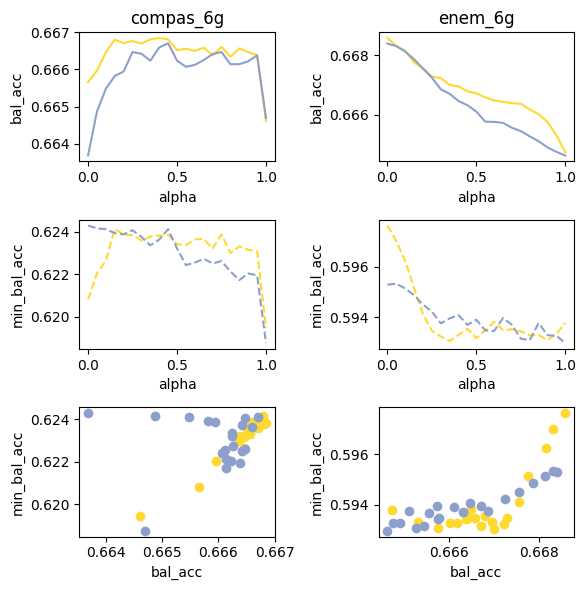

In [41]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### min acc

In [77]:
perf_metric = "acc"
fair_metric = "min_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v3"
)

Total models for M2FGBClassifier, compas_6g : 1000


  0%|                                                                                                             | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


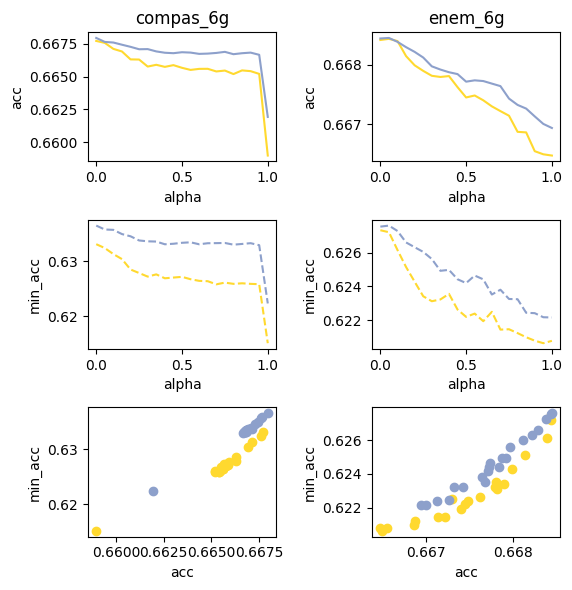

In [71]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

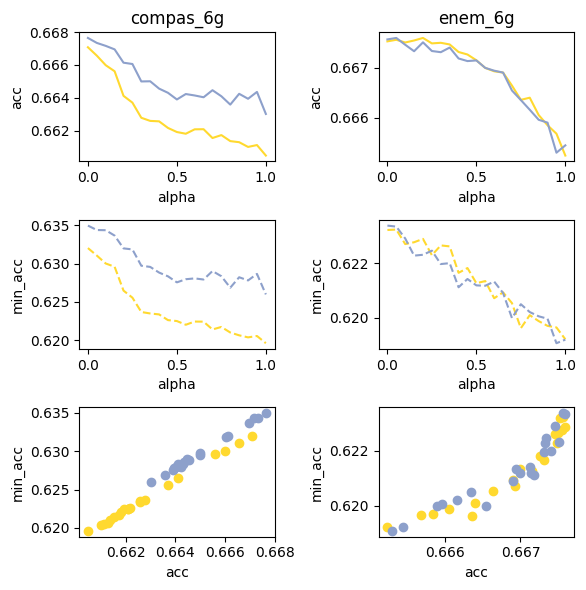

In [78]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### tpr

In [6]:
perf_metric = "bal_acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier_tpr", "LGBMClassifier", "MinimaxPareto_tpr", "MinMaxFair_tpr", "FairGBMClassifier_eod", ]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for MinimaxPareto_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for MinMaxFair_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for FairGBMClassifier_eod, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for M2FGBClassifier_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for MinimaxPareto_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for MinMaxFair_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


Total models for FairGBMClassifier_eod, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


Total models for M2FGBClassifier_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for MinimaxPareto_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


Total models for MinMaxFair_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for FairGBMClassifier_eod, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


Total models for M2FGBClassifier_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for MinimaxPareto_tpr, acsincome_8g : 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for FairGBMClassifier_eod, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


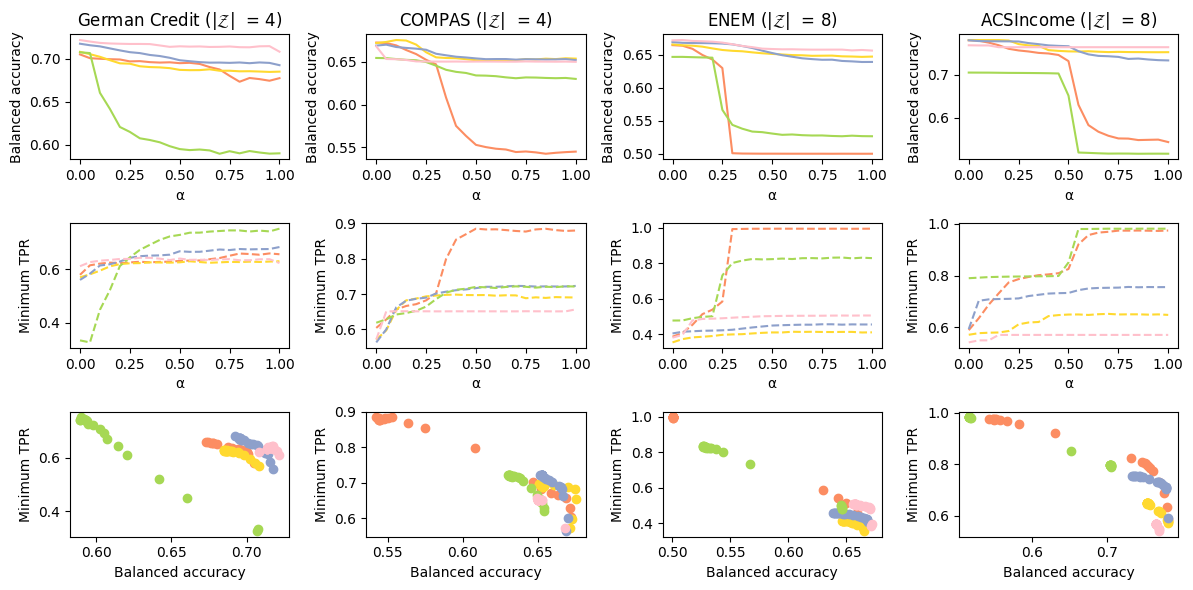

In [7]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("Balanced accuracy")
    axs[1, i].set_ylabel("Minimum TPR")

    axs[2, i].set_xlabel("Balanced accuracy")
    axs[2, i].set_ylabel("Minimum TPR")
plt.tight_layout()

In [8]:
perf_metric = "acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier_tpr", "LGBMClassifier", "MinimaxPareto_tpr", "MinMaxFair_tpr", "FairGBMClassifier_eod", ]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.38it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for MinimaxPareto_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for MinMaxFair_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for FairGBMClassifier_eod, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.40it/s]


Total models for M2FGBClassifier_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for MinimaxPareto_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for MinMaxFair_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for FairGBMClassifier_eod, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for M2FGBClassifier_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


Total models for MinimaxPareto_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.37it/s]


Total models for MinMaxFair_tpr, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.38it/s]


Total models for FairGBMClassifier_eod, enem_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.36it/s]


Total models for M2FGBClassifier_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.37it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for MinimaxPareto_tpr, acsincome_8g : 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for MinMaxFair_tpr, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for FairGBMClassifier_eod, acsincome_8g : 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


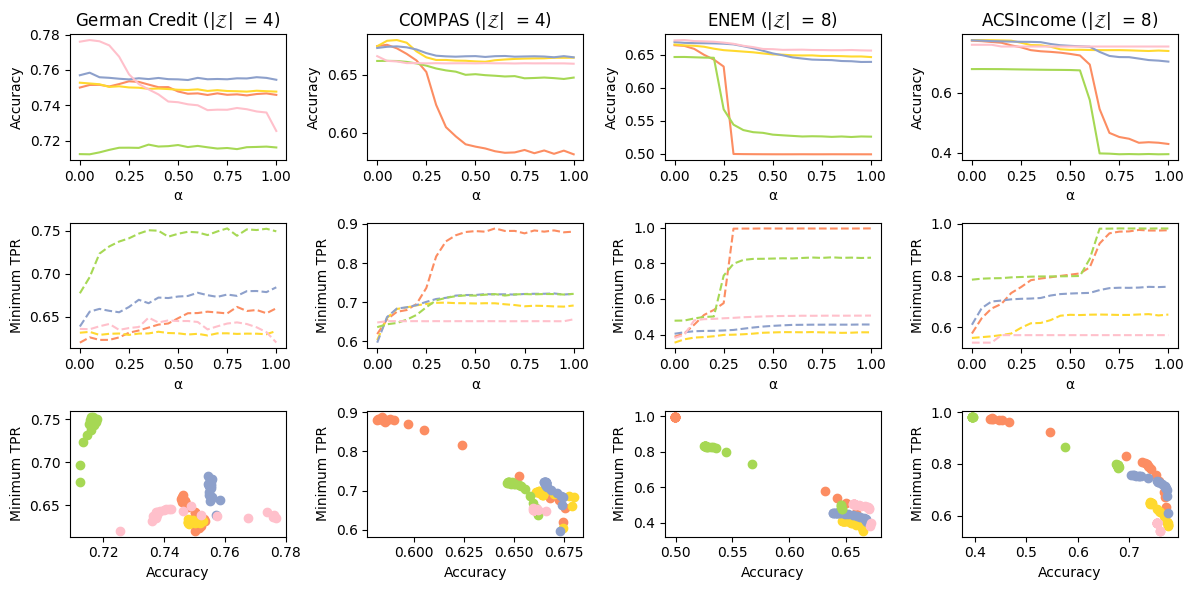

In [15]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("Minimum TPR")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("Minimum TPR")

plt.tight_layout()
plt.savefig("../figs/bench_tpr.pdf", dpi = 300)

In [63]:
perf_metric = "acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g"] #, "enem_8g"]
method_list = ["M2FGBClassifier_tpr", "LGBMClassifier", "FairGBMClassifier_eod", ]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder="../results_aaai/experiment",
)

Total models for M2FGBClassifier_tpr, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.29s/it]


Total models for LGBMClassifier, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.29s/it]


Total models for FairGBMClassifier_eod, german_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.31s/it]


Total models for M2FGBClassifier_tpr, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.28s/it]


Total models for LGBMClassifier, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.35s/it]


Total models for FairGBMClassifier_eod, compas_4g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.26s/it]


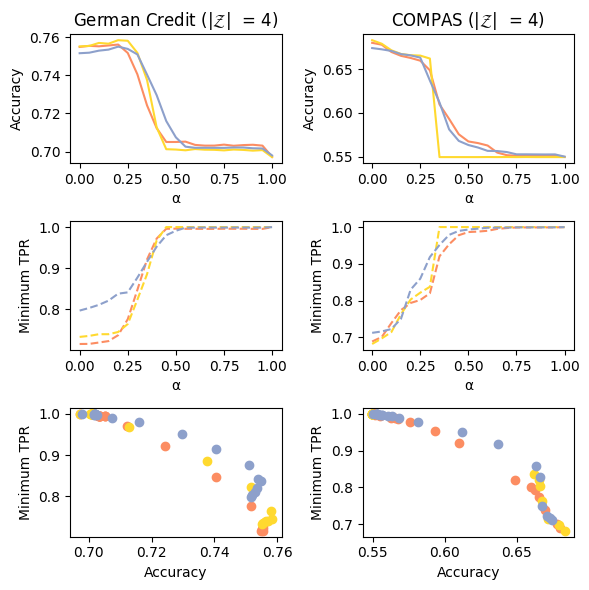

In [64]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("Minimum TPR")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("Minimum TPR")

plt.tight_layout()

(0.0, 1.0, 0.0, 1.0)

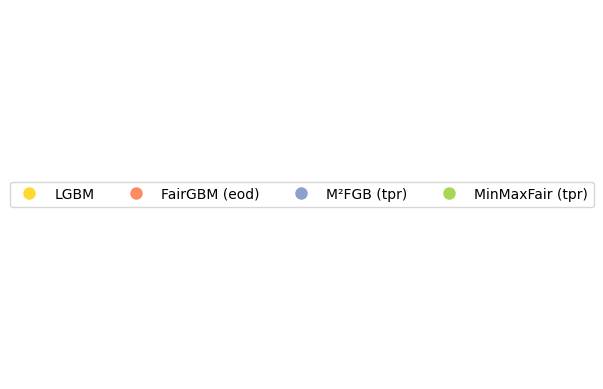

In [41]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_tpr, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")

# verifying why fairgbm has a so high true positive rate

In [23]:
import sys
sys.path.append("../scripts")
import models
import pickle as pkl
import data

In [24]:
args = {"dataset": "acsincome", "n_groups" : 8}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
        data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Female, African-American': 0, 'Male, White': 1, 'Female, White': 2, 'Male, African-American': 3, 'Male, Other': 4, 'Male, Asian': 5, 'Female, Other': 6, 'Female, Asian': 7}


In [26]:
with open("../results_aaai/experiment_new/acsincome_8g/FairGBMClassifier_eod/model.pkl", "rb") as f:
    model = pkl.load(f)

In [51]:
results_test = pd.read_csv("../results_aaai/experiment_new/acsincome_8g/FairGBMClassifier_eod/test.csv")
results_trial = pd.read_csv("../results_aaai/experiment_new/acsincome_8g/FairGBMClassifier_eod/trials.csv")

In [55]:
results_test.isna().mean()

model              0.000
thresh             0.000
bal_acc            0.000
precision          0.000
acc                0.000
recall             0.000
logloss            0.000
min_acc            0.000
min_bal_acc        0.000
min_tpr            0.000
min_pr             0.000
max_logloss        0.000
max_logloss_tpr    0.168
eod                0.000
spd                0.000
eq_loss            0.566
duration           0.000
dtype: float64

In [47]:
# get trial with tpr bigger than 0.9
results_test = results_test[results_test.min_tpr > 0.9]
results_test

,model,thresh,bal_acc,precision,acc,recall,logloss,min_acc,min_bal_acc,min_tpr,min_pr,max_logloss,max_logloss_tpr,eod,spd,eq_loss,duration
68,68,6.689691e-169,0.500354,0.370525,0.371121,0.998785,22.957893,0.179984,0.500000,0.997682,0.995969,inf,NaN,0.002318,0.004031,NaN,0 days 00:00:32.335318
107,107,1.000000e+00,0.559588,0.400729,0.447954,0.990140,20.274715,0.179984,0.500000,0.986204,0.880105,inf,NaN,0.013796,0.119895,NaN,0 days 00:00:07.296869
109,109,1.000000e+00,0.616670,0.438710,0.532054,0.943019,16.901178,0.181134,0.500701,0.922467,0.741318,inf,inf,0.077533,0.257532,NaN,0 days 00:00:10.107509
130,130,1.000000e+00,0.599526,0.424378,0.499678,0.984619,18.252022,0.275462,0.555915,0.925608,0.801507,inf,55.035065,0.068590,0.100891,NaN,0 days 00:00:29.468606
133,133,9.126981e-294,0.531378,0.385865,0.414198,0.983322,21.003973,0.179984,0.500000,0.950468,0.819123,inf,inf,0.049532,0.180877,NaN,0 days 00:00:51.686034
143,143,1.000000e+00,0.622286,0.442528,0.538805,0.944258,16.966173,0.327670,0.544386,0.908808,0.713661,inf,80.393171,0.088531,0.234302,NaN,0 days 00:00:14.702221
145,145,7.667949e-24,0.555233,0.399681,0.453372,0.948091,18.834940,0.179984,0.500000,0.903737,0.725151,inf,NaN,0.096263,0.274849,NaN,0 days 00:00:13.745466
157,157,1.000000e+00,0.554716,0.397787,0.439436,0.999331,20.205766,0.222193,0.519310,0.998823,0.911664,inf,492.552640,0.001177,0.059842,NaN,0 days 00:00:18.069238
196,196,1.000000e+00,0.600521,0.426875,0.508320,0.956124,17.940210,0.223209,0.500000,0.934805,0.725328,inf,NaN,0.065195,0.274672,NaN,0 days 00:00:24.024845
248,248,1.903219e-54,0.556390,0.398916,0.443453,0.991967,20.060081,0.265277,0.500000,0.947394,0.746217,inf,inf,0.052606,0.253783,NaN,0 days 00:00:20.995451


In [48]:
selected_model = model[109]
Y_score_test = selected_model.predict_proba(X_test)
selected_model

FairGBMClassifier(constraint_fnr_tolerance=0.011441534908725516,
                  constraint_type='FNR', learning_rate=0.03463382781369813,
                  min_child_weight=30.83545216638751,
                  multiplier_learning_rate=0.26089401805910856,
                  n_estimators=125, num_leaves=21, random_state=1234,
                  reg_lambda=0.006379528596012381)

In [49]:
Y_score_test[:, 1].mean()

0.7966870884297511

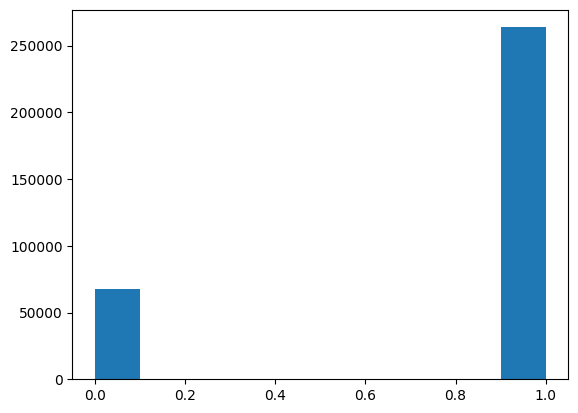

In [50]:
plt.hist(Y_score_test[:, 1]);

In [34]:
results_test.loc[107]

model                                 107
thresh                                1.0
bal_acc                          0.559588
precision                        0.400729
acc                              0.447954
recall                            0.99014
logloss                         20.274715
min_acc                          0.179984
min_bal_acc                           0.5
min_tpr                          0.986204
min_pr                           0.880105
max_logloss                           inf
max_logloss_tpr                       NaN
eod                              0.013796
spd                              0.119895
eq_loss                               NaN
duration           0 days 00:00:07.296869
Name: 107, dtype: object

### mse

In [43]:
perf_metric = "mse"
fair_metric = "max_mse"
dataset_list = ["enemreg_8g"]
method_list = ["M2FGBRegressor", "LGBMRegressor", "MinMaxFairRegressor"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    maximize=False,
)

Total models for M2FGBRegressor, enemreg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.06s/it]


Total models for LGBMRegressor, enemreg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


Total models for MinMaxFairRegressor, enemreg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03s/it]


In [36]:
df_results_ = df_results.copy()


In [37]:
df_results = df_results_.copy()
df_results = df_results[df_results.model != "MinMaxFairRegressor"]

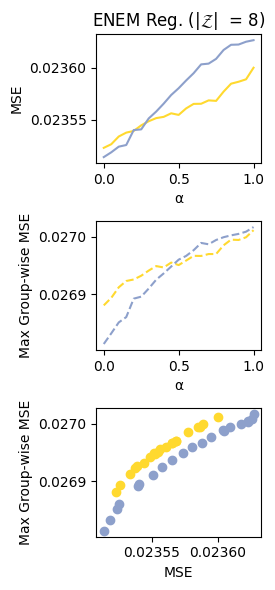

In [41]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("MSE")
    axs[1, i].set_ylabel("Max Group-wise MSE")

    axs[2, i].set_xlabel("MSE")
    axs[2, i].set_ylabel("Max Group-wise MSE")
plt.tight_layout()

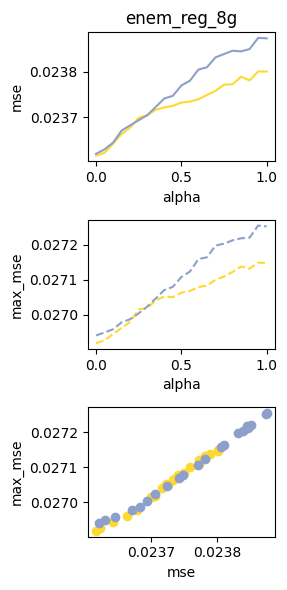

In [101]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

def plot_results(axs, df_results):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
    #for i, model in enumerate(["M2FGBRegressor", "LGBMRegressor"]):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")
        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)


for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)


plt.tight_layout()

## testing bugs

In [25]:
from glob import glob

In [29]:
files = glob("../results_aaai/experiment_new/*/*/*.pkl")
# print size of the files
import os
for file in files:
    size = os.path.getsize(file)
    print(file)
    print(size / 1024 / 1024 / 1024, "GB")

../results_aaai/experiment_new/enem_large_27g/M2FGBClassifier/model.pkl
0.40539364144206047 GB
../results_aaai/experiment_new/enem_large_27g/FairGBMClassifier/model.pkl
0.04085613042116165 GB
../results_aaai/experiment_new/enem_large_27g/LGBMClassifier/model.pkl
0.337285821326077 GB
../results_aaai/experiment_new/german_4g/M2FGBClassifier_tpr/model.pkl
0.14252062235027552 GB
../results_aaai/experiment_new/german_4g/MinMaxFair_tpr/model.pkl
0.002056366764008999 GB
../results_aaai/experiment_new/german_4g/MinimaxPareto_tpr/model.pkl
0.2573829470202327 GB
../results_aaai/experiment_new/acsincome_8g/M2FGBClassifier_tpr/model.pkl
0.005699389614164829 GB
../results_aaai/experiment_new/acsincome_8g/FairGBMClassifier_eod/model.pkl
0.0025876248255372047 GB
../results_aaai/experiment_new/acsincome_8g/MinMaxFair_tpr/model.pkl
0.00018728896975517273 GB
../results_aaai/experiment_new/acsincome_8g/FairGBMClassifier/model.pkl
0.15875260718166828 GB
../results_aaai/experiment_new/acsincome_8g/MinimaxP

In [30]:
# delete file if it has more than 1GB
for file in files:
    size = os.path.getsize(file)
    if size > 1024 * 1024 * 1024:
        os.remove(file)
        print(f"Deleted {file}")

Deleted ../results_aaai/experiment_new/acsincome_8g/MinimaxPareto_tpr/model.pkl
Deleted ../results_aaai/experiment_new/enem_8g/MinimaxPareto_tpr/model.pkl


In [1]:
import sys
sys.path.append("../scripts")
import data
import models


%load_ext autoreload
%autoreload 2

(X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test) = data.get_strat_split("enemreg", 4, 20, 0)

{'Brown_1.0': 0, 'Black_0.0': 1, 'White_0.0': 2, 'Asian_0.0': 3, 'Brown_0.0': 4, 'Black_1.0': 5, 'White_1.0': 6, 'Native_1.0': 7, 'Native_0.0': 8, 'Asian_1.0': 9}


In [10]:
m = models.MinMaxFairRegressor(n_estimators=5).fit(X_train, Y_train, A_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Converging early at round 4
0.0


In [11]:
y_val = m.predict(X_val)
((y_val - Y_val)**2).max()

7.650798554351814e+22

In [9]:
((y_val - Y_val)**2).max()

0.3389976993616916